**Paper Findings**

This paper intended to implement a ViT for image classifcation by utilizing a standard transformer with some data transforms to allow for a standard NLP transformer to work on images. They then decided to compare this network to state-of-the art Convolutional Networks which dominate image classifcation. Interestingly they found that for large datasets this ViT was actually able to perform better than CNN's. However, this performance was not mainted when trained on small/medium datasets.



**Homework Introduction**

In this homework we hope to explore how the paper implemented its model on a smaller dataset. In order to do so, first we will take an image and do a data transformation to convert it to a positionally encoded image with 16x16 patches. We will then feed that into a ViT(Vision Transformer) Model and train this model on the CIFAR-10 Dataset(a small dataset). To get an understaning of its performance we will compare it to a pre-trained CNN also trained on CIFAR-10. This should give us an understanding of what the paper actually implemented code wise on a small easy to train dataset.

We will then explore some questions about how transformers are able to achieve similar performance as CNN's without having the same inductive biases. We will then also explore some results found in the paper relating to positional encoding, computation estimations, and scaling. This will allow us to understand how the paper achieved the results it did on medium and larger datasets without needing insane compute. 

Reference Paper: https://arxiv.org/pdf/2010.11929.pdf



In [ ]:
!pip install einops
!pip install symjax
!pip install -qq dm-pix
!pip install flax

In [ ]:
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax
import jax
import tqdm
from collections import defaultdict

## Just run the cell below, you dont need to understand it

In [ ]:
# Utils.py
import jax
from jax import lax
from jax import random
import jax.numpy as jnp
import flax.linen as nn
import flax
from flax.training import train_state, checkpoints
import os
import json
import tqdm
import pickle
import matplotlib.pyplot as plt
import sys
import numpy as np

import optax

from tqdm import  tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

class Trainer:
    
    H = W = 32
    C = 3
    metadata_filename = "metadata.txt"
    
    def __init__(self, ckpt_dir:str, model_class: nn.Module, model_h_params: dict, batch_size: int, optimizer_name: str,
                 optimizer_args: dict, preloaded=False):
        """
            :param ckpt_dir : Path to directory where checkpoints are saved/should be saved
            :param model_class : Class of flax module that represents the model
            :param model_h_params: *args that model_class takes
            :param batch_size
            :param optimizer_name: Choose from 'sgd', 'adam', 'adamw'
            :param optimizer_args: *args that the corresponding optax optimizer takes
            :param preloaded: If true all args except model_class are ignored and loaded from metadata
        """
        
        self.ckpt_dir = ckpt_dir
        
        self.model_class = model_class
        self.model_h_params = model_h_params
        self.batch_size = batch_size
        self.optimizer_name = optimizer_name
        self.optimizer_args = optimizer_args
        self.dropout_key = random.PRNGKey(0)
        self.dropout_step = 0
        
        assert os.path.isdir(ckpt_dir), "Path is not directory or does not exist"
        
        if not preloaded:
            self.initialise()
            self.opt_state = self.tx.init(self.params)
        else:
            self.__load_model()
        self.create_functions()
    
    def initialise(self):
        try:
            if self.optimizer_name == "sgd":
                self.tx = optax.sgd(**self.optimizer_args)
            elif self.optimizer_name == "adam":
                self.tx = optax.adam(**self.optimizer_args)
            elif self.optimizer_name == "adamw":
                self.tx = optax.adamw(**self.optimizer_args)
            else:
                raise ValueError("Invalid optimizer name")
        except:
            raise ValueError("Invalid optimizer args")

        key1, key2 = random.split(random.PRNGKey(0), 2)
        x = random.uniform(key1, (self.H, self.W, self.C))
        x.shape

        try:
            self.model = self.model_class(**self.model_h_params)
        except:
            raise ValueError("Invalid model args")

        model_init_param = self.model.init(key2, x, train=False)
        self.params = model_init_param
    
   
    def create_functions(self):
    
        def cross_entropy(params, x_batched, y_batched):
            # Define the squared loss for a single pair (x,y)
            def loss(x, y):
                if 'batch_stats' in params:
                    pred, new_params = self.model.apply({'params': params['params'], 'batch_stats': params['batch_stats']}, x, mutable=['batch_stats'])
                else:
                    dropout_rng = jax.random.fold_in(self.dropout_key, self.dropout_step)
                    pred = self.model.apply(params, x, train=True, rngs={'dropout': dropout_rng})
                labels_onehot = jax.nn.one_hot(y, num_classes=10)
                return optax.softmax_cross_entropy(logits=pred, labels=labels_onehot).mean()

            # Vectorize the previous to compute the average of the loss on all samples.
            return jnp.mean(jax.vmap(loss)(x_batched,y_batched), axis=0)

        def num_correct(params, x_batched, y_batched):
            def correct(x, y):
                if 'batch_stats' in params:
                    pred, new_parmas = self.model.apply({'params': params['params'], 'batch_stats': params['batch_stats']}, x, mutable=['batch_stats'])
                else:
                    pred = self.model.apply(params, x, train=False)
                pred_label = jnp.argmax(pred)
                return pred_label == y
            return jnp.sum(jax.vmap(correct)(x_batched, y_batched), axis=0)

        self.cross_entropy = jax.jit(cross_entropy)
        self.num_correct = jax.jit(num_correct)
            
    def get_accuracy(self, params, X, y):
        generator = yield_batches(X, y, B, False, False)
        acc = 0
        for X_batch, y_batch in generator:
            acc += self.num_correct(params, X_batch, y_batch)
        return acc/X.shape[0]
    
    def batched_apply(self, x_batched):
         return jax.vmap(self.model.apply,(None, 0))(self.params, x_batched)

    def visualize_test(self, num_img=4):
        # Visualize some images and results
        params = self.params
        labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        def visualise(x, y):
          if 'batch_stats' in params:
            logits, _ = self.model.apply({'params': params['params'], 'batch_stats': params['batch_stats']}, x, mutable=['batch_stats'])
          else:
            logits = self.model.apply(params, x, train=False)

          plt.imshow(x, interpolation='nearest')
          print(f"True label = {labels[int(y)]}", f"\tModel label = {labels[int(logits.argmax(axis=-1))]}")
          plt.show()

        i = 0
        data_loader = yield_batches(valid_X, valid_y, self.batch_size, False, False)
        for batch in data_loader:
          X, Y = batch
          X = X * jnp.array([0.2023, 0.1994, 0.2010]) + jnp.array([0.4914, 0.4822, 0.4465])
          plt.figure()
          train = False
          for i, (x, y) in enumerate(zip(X, Y)):
              visualise(x,y)
              if i >= num_img:
                break
          break
        return
  
    
    def __save_model(self, step):
        assert os.path.isdir(self.ckpt_dir), "Path is not directory or does not exist"
        save_metadata = {
            "batch_size": self.batch_size,
            "optimizer_name": self.optimizer_name,
            "optimizer_args": self.optimizer_args,
            "model_h_params": self.model_h_params
        }
        with open(os.path.join(self.ckpt_dir, self.metadata_filename), 'w') as f:
            f.write(json.dumps(save_metadata))
            
        state = train_state.TrainState.create(apply_fn=self.model.apply,
                                              params=self.params,
                                              tx=self.tx)
        try:
            checkpoints.save_checkpoint(ckpt_dir=self.ckpt_dir, target=state, step=step)
        except:
            print(f"\t\tSkipping because already saved better ckpt")
    
    def __load_model(self):
        assert os.path.isdir(self.ckpt_dir), "Path is not directory or does not exist"
        assert os.path.isfile(os.path.join(self.ckpt_dir, self.metadata_filename)), "Save metadata does not exist"
        
        ckpt = checkpoints.latest_checkpoint(self.ckpt_dir)
        assert not (ckpt is None), "Checkpt file not found"
        
        
        with open(os.path.join(self.ckpt_dir, self.metadata_filename)) as f:
            save_metadata = json.loads(f.read())
        self.batch_size = save_metadata["batch_size"]
        self.optimizer_name = save_metadata["optimizer_name"]
        self.optimizer_args = save_metadata["optimizer_args"]
        self.model_h_params = save_metadata["model_h_params"]
        self.initialise()

        state = checkpoints.restore_checkpoint(ckpt, target=None)
        self.params = state["params"]
        self.opt_state = state["opt_state"]
        
    def train_model(self, num_epochs, train_X, train_y, valid_X=None, valid_y=None, data_augmentation=True):
        loss_grad_fn = jax.value_and_grad(self.cross_entropy)
        num_iters = int(jnp.ceil(len(train_X)/self.batch_size))
        
        train_accs = []
        val_accs = []
        print(num_epochs)
        for epoch in range(num_epochs):
            train_batch_generator = yield_batches(train_X, train_y, self.batch_size, False, data_augmentation)
            print("\nEpoch =", epoch)
            for i, (batched_x, batched_y) in tqdm(enumerate(train_batch_generator), total=num_iters):
                self.dropout_step += 1
                loss, grads = loss_grad_fn(self.params, batched_x, batched_y)
                updates, opt_state = self.tx.update(grads, self.opt_state)
                params = optax.apply_updates(self.params, updates)
                self.opt_state, self.params = opt_state, params

            
            step=epoch
            train_acc = float(self.get_accuracy(self.params, train_X, train_y))
            train_accs.append(train_acc)
            print(f'Training acc :{train_acc}')
            if not valid_X is None and not valid_y is None:
                valacc = self.get_accuracy(self.params, valid_X, valid_y)
                val_accs.append(valacc)
                print(f'Validation acc {float(valacc)}')
                step=valacc
            
            try:    
                print(f'\t\tSaving checkpoint...')
                self.__save_model(step)
            except Exception as e:
                print(f"\t\tSkipping because already saved better ckpt")
        
        return train_accs, val_accs


def downloading(path, source='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'):
    if sys.version_info[0] == 2:
        from urllib import urlopen
    else:
        from urllib.request import urlopen
    
    import tarfile
    if not os.path.exists(path):
        os.makedirs(path)
    u = urlopen(source)
    with tarfile.open(fileobj=u, mode='r|gz') as f:
        f.extractall(path=path)
    u.close()


def loading(path):
    downloading(path)

    train_data = [pickle.load(open(os.path.join(path, 'cifar-10-batches-py', 'data_batch_%d' % (i + 1)), 'rb'),
                              encoding='latin1') for i in range(5)]

    X_train = np.vstack([d['data'] for d in train_data])
    y_train = np.hstack([np.asarray(d['labels'], np.int8) for d in train_data])

    test_data = pickle.load(open(os.path.join(path, 'cifar-10-batches-py', 'test_batch'), 'rb'), encoding='latin1')
    X_test = test_data['data']
    y_test = np.asarray(test_data['labels'], np.int8)

    X_train = X_train.reshape(-1, 3, 32, 32)
    X_train = X_train.transpose(0,2,3,1)
    X_test = X_test.reshape(-1, 3, 32, 32)
    X_test = X_test.transpose(0,2,3,1)

    return X_train, y_train, X_test, y_test



def identity(x):
    return x


def rotation(x, prob):
    return jax.lax.cond(prob, jnp.rot90, identity, x)


def horizontal_flip(x, prob):
    return jax.lax.cond(prob, jnp.fliplr, identity, x)
    
    
def vertical_flip(x, prob):
    return jax.lax.cond(prob, jnp.flipud, identity, x)


def pighead(x):
    r_start = random.randint(key=random.PRNGKey(1126), shape=(1,), minval=0, maxval=7)[0]
    c_start = random.randint(key=random.PRNGKey(1126), shape=(1,), minval=0, maxval=7)[0]
    x = jnp.pad(x, pad_width = np.array([[4, 4], [4, 4], [0, 0]]),\
                mode = "constant", constant_values=np.array([[0.4914], [0.4822], [0.4465]]))
    return jax.lax.dynamic_slice(x, (r_start, c_start, 0), (32, 32, 3))


def jigsaw(x, prob):
    return jax.lax.cond(prob, pighead, identity, x)


rotation_jit = jax.jit(jax.vmap(rotation, in_axes=(0, 0)))
horizontal_flip_jit = jax.jit(jax.vmap(horizontal_flip, in_axes=(0, 0)))
vertocal_flip_jit = jax.jit(jax.vmap(vertical_flip, in_axes=(0, 0)))
jigsaw_jit = jax.jit(jax.vmap(jigsaw, in_axes=(0, 0)))


def plot_samples(X, y, num_rows, num_columns, figsize=(12, 8), title=None):
    # Need to un-standardize X to clip pixel values to [0.0, 1.0]
    X = X * jnp.array([0.2023, 0.1994, 0.2010]) + jnp.array([0.4914, 0.4822, 0.4465])

    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    for i in range(num_rows * num_columns):
        img = X[i]
        label = str(y[i])
        ax[i // num_columns, i % num_columns].imshow(img.reshape(32, 32, 3))
        ax[i // num_columns, i % num_columns].set_title(label)
        ax[i // num_columns, i % num_columns].axis("off")

    if title:
        plt.suptitle(str(title))
    plt.show()


# If shuffle == True, then the original arrays would be shuffled as well.
# So if you want to keep the original ones, please make the copies before
# passing them to this function
def yield_batches(X, y, batch_size, shuffle=False,
                  contamination = True, key = 1126):
    assert len(X) == len(y)
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    for i in range(0, len(X) - batch_size + 1, batch_size):
        batch_indices = slice(i, i + batch_size)

        if contamination:
            yield contamination_factory(X[batch_indices], key = random.PRNGKey(key)), y[batch_indices]
        else:
            yield X[batch_indices], y[batch_indices]

# Implement Dataloader

Complete the TODOs in the cells below to have a functioning dataloader. The data loader implements data augmentation as well. Make sure to tune the probabilities for augmentation to what you find best and turn off any specific augmentations you think are not helpful.

In [ ]:
# Dataloader Loading - Ben
import os
import sys
import numpy as np

import jax
import jax.numpy as jnp
from jax import random
from jax import grad, vmap, pmap, jit
from functools import partial

%config IPCompleter.use_jedi = False

label_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [ ]:
def train_validation_split(X, y, ratio):
    dataset_size = len(X)
    label_size = len(y)
    assert dataset_size == label_size
    assert ratio <= 1 and ratio > 0
    validation_size = int(ratio * dataset_size)
    ############################################
    # Split X and y based on the inputted ratio.
    # Make sure the label is not messed up.
    ############################################
    # TODO (To delete in the student version)
    random_indicies = ...

    train_X = ...
    train_y = ...
    validation_X = ...
    validation_y = ...

    return train_X, train_y, validation_X, validation_y
    # TODY Ends Here

In [ ]:
X_train, y_train, X_test, y_test = loading('.')
X_train_scaled = jnp.array(X_train / 255.)
X_test_scaled = jnp.array(X_test / 255.)
y_train_hot = jnp.squeeze(jax.nn.one_hot(y_train, num_classes=10))
y_valid_hot = jnp.squeeze(jax.nn.one_hot(y_test, num_classes=10))
X_train_standardized =\
  jax.nn.standardize(x = X_train_scaled,
                     mean = jnp.array([0.4914, 0.4822, 0.4465]),
                     variance = jnp.array([0.2023**2, 0.1994**2, 0.2010**2]))
X_test_standardized = \
  jax.nn.standardize(x = X_test_scaled,
                     mean = jnp.array([0.4914, 0.4822, 0.4465]),
                     variance = jnp.array([0.2023**2, 0.1994**2, 0.2010**2]))
train_X, train_y, valid_X, valid_y =\
  train_validation_split(X_train_standardized, y_train, 0.2)


##########################################################################
# Please tune the following 4 p's to increase your accuracy.
# You can also choose a combinatino of augmentation you like.
##########################################################################
# TODO
def contamination_factory(X, key):
    batch_size = len(X)
    
    # Random cropping with padding
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = jigsaw_jit(X, prob)

    #Random rotation by 90 degree
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = rotation_jit(X, prob)
    
    # Random horizontal flip
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = horizontal_flip_jit(X, prob)
    
    #Random vertical flip
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = vertocal_flip_jit(X, prob)

    return X

# TODO Ends Here (Please don't delete the above lines)

In [ ]:
sample_size = 30
indices = np.arange(len(train_X))
random_idx = np.random.choice(indices, size=(sample_size))

sample_X = train_X[random_idx]
sample_y = train_y[random_idx]

sample_label_dict = [label_dict.get(i) for i in sample_y]

plot_samples(
    X=sample_X,
    y=sample_label_dict,
    num_rows = 5, num_columns = 6,
    title = "Lucky Samples"
)

sample_X_contaminated = contamination_factory(
    sample_X, key=random.PRNGKey(0)
)

plot_samples(
    X=sample_X_contaminated,
    y=sample_label_dict,
    num_rows = 5, num_columns = 6,
    title = "Contaminated Samples"
)

# Transformer Encoder

The paper describes that the model uses a transformer encoder to process the linear image embeddings. Complete the TODOs in transformer_student.py and check your implementation by running the cells below.

Use this image as a reference for how you need to implement the encoder

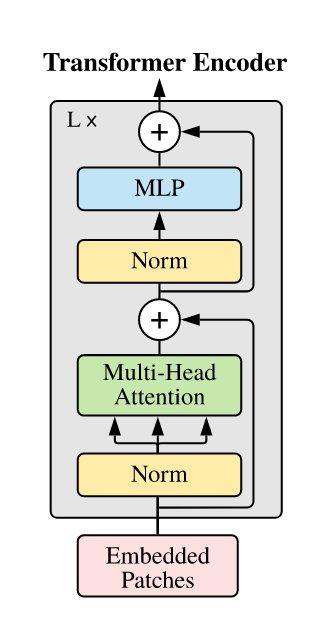

In [ ]:
import pickle
from transformer_student import *
from ViT_student import *

In [ ]:
#Encoder Block Unit test
with open('unit_tests/Encoder_call_test.pkl', 'rb') as file:
    Encoder_call_test_data = pickle.load(file)
    model_h_params = Encoder_call_test_data["h_params"]
    model = EncoderBlock(**model_h_params)
    params = Encoder_call_test_data["params"]
    
    for data in Encoder_call_test_data["data"]:
        inp = data["input"]
        correct_output = data["output"]
        output = model.apply(params, inp, train=False)
        assert output.shape == correct_output.shape, f"Your output shape : {output.shape}, Expected : {correct_output.shape}"
        assert jnp.sum((correct_output - output)**2) <= 1e-4

In [ ]:
#Transformer Encoder Unit test
with open('unit_tests/Transfer_call_test.pkl', 'rb') as file:
# Call load method to deserialze
    Transformer_call_test_data = pickle.load(file)
    model_h_params = Transformer_call_test_data["h_params"]
    model = TransformerEncoder(**model_h_params)
    params = Transformer_call_test_data["params"]
    
    for data in Transformer_call_test_data["data"]:
        inp = data["input"]
        correct_output = data["output"]
        output = model.apply(params, inp, train=False)
        assert output.shape == correct_output.shape, f"Your output shape : {output.shape}, Expected : {correct_output.shape}"
        assert jnp.sum((correct_output - output)**2) <= 1e-3

# ViT Model

Complete the TODOs in ViT_student.py: 

*   Implement the patchify method which splits the image into patches of size number of channels x patch size x patch size
*   Implement the __call__ method to patchify the input image, do a linear projection onto the embedding dimension, prepend the CLS token, and add the positional encoding

Run the following cells to check your implementation. 

Use this image as reference to help with implementation.

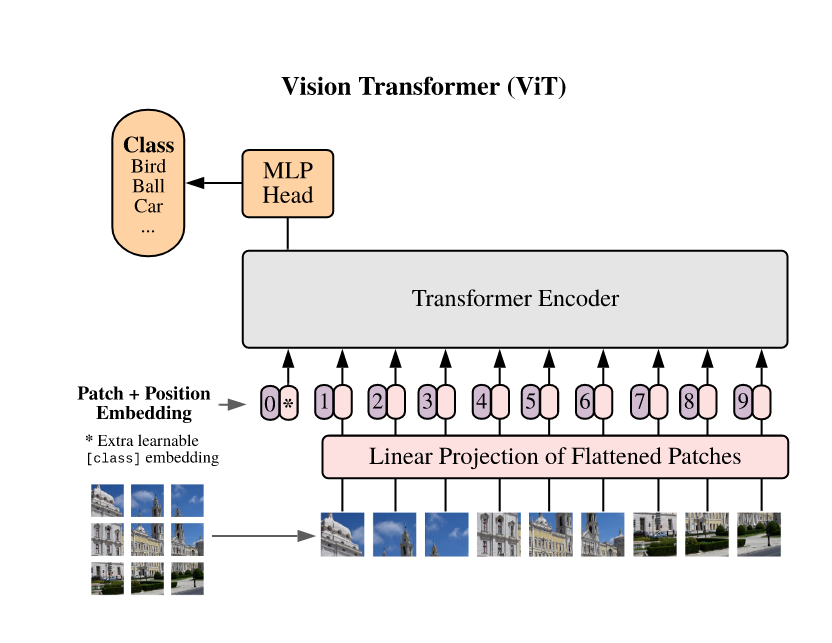

In [ ]:
# Patchify unit test

with open('unit_tests/patchify_test.pkl', 'rb') as file:
# Call load method to deserialze
    patchify_test_data = pickle.load(file)
    model_params = patchify_test_data["h_params"]
    model = ViT(**model_params)

    i = 0
    for data in patchify_test_data["data"]:
        inp = data["input"]
        correct_output = data["output"]
        output = model.patchify(*inp)
        assert output.shape == correct_output.shape, f"Your output shape : {output.shape}, Expected : {correct_output.shape}"
        assert jnp.sum((correct_output - output)**2) <= 1e-4


Now let's visualise what the patchify function is doing ...

In [ ]:
# ViT unit test

with open('unit_tests/Vit_call_test.pkl', 'rb') as file:
# Call load method to deserialze
    Vit_call_test_data = pickle.load(file)
    model_params = Vit_call_test_data["h_params"]
    model = ViT(**model_params)
    params = Vit_call_test_data["params"]
    
    for data in Vit_call_test_data["data"]:
        inp = data["input"]
        correct_output = data["output"]
        output = model.apply(params, inp, train=False)
        assert output.shape == correct_output.shape, f"Your output shape : {output.shape}, Expected : {correct_output.shape}"
        assert jnp.sum((correct_output - output)**2) <= 1e-3
    
    inp = X_train[100]
    output = model.patchify(inp, 4)

    plt.imshow(inp)
    plt.title("Original Image")
    plt.show()
    model.visualize_patching(np.array(output), model.num_patches, model.num_patches, inp.shape[2])

# ViT Training

Train the ViT model you wrote on the CIFAR-10 dataset. Adjust the hyperparameters to try and get better validation accuracy.

You must atleast get 50% validation accuracy to pass this section

In [ ]:
#VIT TRAINING

B=128
H = W = 32
C = 3

# TODO: Change hyperparameters below if needed:

num_epochs = 10
patch_size = 4

model_params = {
    "patch_size" : patch_size,
    "embedding_dim" : 256,
    "num_patches" : H//patch_size,
    "n_classes" : 10,
    "n_heads" : 4,
    "n_layer" : 4,
    "feedforward_dim" : 1025,
    "dropout" : 0.1
}

optim_params = {
    "learning_rate": 0.0001, 
    "b1": 0.9, 
    "b2": 0.95
}


#Training model from scratch
trainer = Trainer(".", ViT, model_params, B, "adam", optim_params)
train_accs, val_accs = trainer.train_model(num_epochs, train_X, train_y, valid_X, valid_y, True)
best_val_acc = max(val_accs)
assert best_val_acc >= 0.5, f"Validation accuracy of {best_val_acc} not passing threshhold of {0.5}"

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label="Training accuracy")
plt.plot(val_accs, label = "Validation accuracy")
plt.xlabel("Num epochs")
plt.title("Accuracy vs Num Epochs")
plt.legend()
plt.show()

In [ ]:
trainer.visualize_test()

# ResNet CNN

CNN models and specifically ResNet is often considered the state of the art network for image classification. The following table shows the performance of different CNN models with different activation functions, and here we see some incredibly strong accuracy metrics.  The inductive biases that underly CNN's make them very strong for image classification, and thus make it a good metric for comparing the strength of our model. 


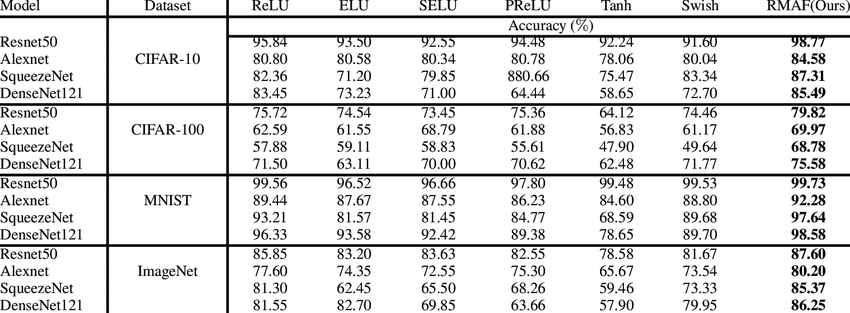


Recall that a ResNet is built of 2 major building blocks as shown below. We use this basic architecture to implement our benchmark JAX ResNet below. In this part we will train this ResNet to get a benchmark to contextualize the effectiveness of our ViT model.


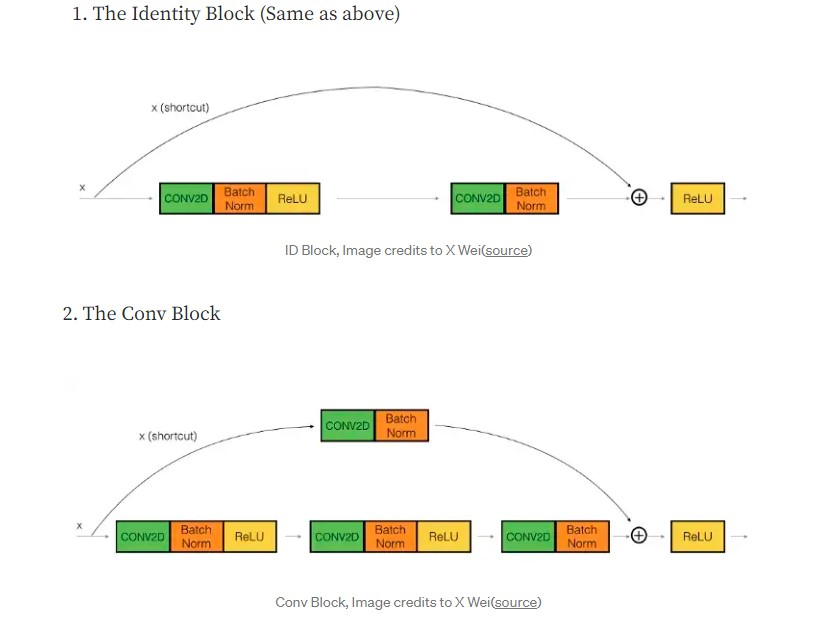

In [ ]:
#RESNET TRAINING  - Sarthak 

resnet_kernel_init = nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal')
class ResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(x)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)

        if self.subsample:
            x = nn.Conv(self.c_out, kernel_size=(1, 1), strides=(2, 2), kernel_init=resnet_kernel_init)(x)

        x_out = self.act_fn(z + x)
        return x_out

class ResNet(nn.Module):
    num_classes : int
    act_fn : callable
    block_class : nn.Module
    num_blocks : tuple = (3, 3, 3)
    c_hidden : tuple = (16, 32, 64)

    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(self.c_hidden[0], kernel_size=(3, 3), kernel_init=resnet_kernel_init, use_bias=False)(x)
        if self.block_class == ResNetBlock:  # If pre-activation block, we do not apply non-linearities yet
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)

        # Creating the ResNet blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)
                # ResNet block
                x = self.block_class(c_out=self.c_hidden[block_idx],
                                     act_fn=self.act_fn,
                                     subsample=subsample)(x, train=train)

        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

**TODO:**

Now that we have defined our ResNet Architecture, use the Trainer Class to train this model. Report its train and validation accuracy as it trains and visualize some of the results(label and images) of the final model. Try playing with different hyperparamters like learning_rate, momentum, and batch_size to get decent results. Try tuning this hyperparameters until you get a train and validation accuracy both above 60%. You shouldn't have to run more than 15 epochs to get this result.

(HINT: This shouldn't involve writing code, simply call the existing methods in TrainerModule and tune they hyperparameters)





In [ ]:
##########################################################################
# VISUALIZE RESULTS
# REPORT ACCURACY
##########################################################################
# TODO

#RES-NET Training
B=128
H = W = 32
C = 3
num_epochs = 7 # blank out number

model_hparams={"num_classes": 10,"c_hidden": (16, 32, 64),"num_blocks": (3, 3, 3), "act_fn": nn.relu, "block_class": ResNetBlock}
optimizer_name="sgd"
optimizer_hparams={"learning_rate": 0.1, "momentum": 0.9} # blank out numbers

#Training model from scratch
trainer = Trainer(".", ResNet, model_hparams, B, optimizer_name, optimizer_hparams) # blank out
train_accs, val_accs = trainer.train_model(num_epochs, train_X, train_y, valid_X, valid_y) # blank out
trainer.get_accuracy(trainer.params, valid_X, valid_y) #blank out

import matplotlib.pyplot as plt

plt.plot(train_accs, label="Training accuracy")
plt.plot(val_accs, label = "Validation accuracy")
plt.xlabel("Num epochs")
plt.title("Accuracy vs Num Epochs")
plt.legend()
plt.show()

In [ ]:
trainer.visualize_test()

In [ ]:
#ANALYTICAL QUESTIONS - ALL

QUESTION: We saw that the RESNET Model performed very well on the CIFAR10 DataSet. What are some of the inductive biases that allow CNN's in general to perform well for image classification? 

SOLUTION: ...

QUESTION: Do Transformers have any inherent inductive bias? In the paper we see transformers hold up and surpass accuracy bench mark tests against the CNN's for image classification? How is this possible?


SOLUTION: ...

QUESTION: Does transforming the images into 16x16 patches and feeding the positional locations of such patches give the transformer an inductive bias towards locality or spatial relation? Would embedding the 2D location of each patch yield significant improvements?

SOLUTION: ...



QUESTION: Why is scaling necessary in preprocessing the images in CIFAR-10?

SOLUTION: ...

QUESTION: Can we simply add the position encoding to each patch? Please explain.

SOLUTION: ...

QUESTION: How does the accuracy of the transformer model change when trained on different size datasets? With this information when is it appropriate to use a transformer ViT over a ResNet?

SOLUTION: ...